### Facies Prediction - Deep Learning

Here we will get you started using deep learning to associate a suite of well-log measurements, with set of lithofacies. To start with we have a set of facies labels made from an interpreter, we train a model and predict to a blind well. Exact details of the problem can be found in the seminal paper by Hall (2016); https://doi.org/10.1190/tle35100906.1. A with problems with a simple point-wise machine learning solution it exhibits high frequency noise in its prediction. Instead of looking at the data point-wise, we want a machine to look at a scene in a broader context. Borrowing from natural language processing and deep learning we show a baseline implementation using a method call LSTM, looking at the broader scene gives commensurate predictive power, but without the unphysical noise. 

If you want to try this out for yourself you can find the datasets and example notebooks here
https://agilescientific.com/blog/2016/12/8/seg-machine-learning-contest-theres-still-time

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

import pandas as pd
import numpy as np

import matplotlib.pylab as plt

# This is fast if you have GPU!
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input, Embedding, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.initializers import Zeros

from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# Convenience method from the seminal work of https://github.com/brendonhall
from competition_facies_plots import make_facies_log_plot, compare_facies_plot, facies_colors

Using TensorFlow backend.


Find code and datasets at the agile geoscience github repos https://github.com/seg/2016-ml-contest. It's crucial we do our test/train split in a realistic way, here we will hold out a blind-well and train on the remainder of the collection. In later version we will show how to iterate this to predict likely performance in the wild. The data we might use in training needs to be normalized to help the model learn.

In [2]:
all_data = pd.read_csv("training_data.csv")
# stuff not to normalize
_not_keys = ['Facies', 'Formation', 'Well Name']
# stuff to normalize
_norm_keys = ['Depth', 'GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']

all_wells = {}
for key, val in all_data.groupby("Well Name"):
    all_wells[key] = val.copy()

Tell us about the scene; load the well-data into short snippets, and associate label with the center of of the scene.

In [3]:
def chunk(x, y, num_chunks, size=61, random=True):
    rng = x.shape[0] - size
    if random:
        indx = np.int_(np.random.rand(num_chunks) * rng) + size//2
    else:
        indx = np.arange(0,rng,1) + size//2
        
    Xwords = np.array([[x[i-size//2:i+size//2+1,:] for i in indx]])
    ylabel = np.array([y[i] for i in indx])
    return Xwords[0,...], ylabel

Organize the test/train split. The LSTM requires it's ground truth as in "Hot-One" format, and we need to make sure to pad the size of the data to be a multiple of the batch size using in training. This let's use take advantage of the "stateful" option, that lets information flow from one epoch of training to the next. Letting LSTM have a better view of the overall scene. 

In [4]:
def _num_pad(size, batch_size):
    return (batch_size - np.mod(size, batch_size))

def setup_svc(blind_well='SHANKLE', 
              holdout_wells=["STUART", "CRAWFORD"],
              wvars=['GR', 'DeltaPHI', 'PE', 'PHIND', 'ILD_log10', 'NM_M'],
              win=7):
        
    X_train = []
    y_train = []
    for key,val in all_wells.items():
        if key == blind_well or key in holdout_wells:
            continue
        X_train.extend(val[wvars].values)
        y_train.extend(val['Facies'].values)
        
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    _scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = _scaler.transform(X_train)    
    
    if blind_well is not None:
    
        blind = all_wells[blind_well].copy() 

        X_test = blind[wvars].values
        y_test = blind['Facies'].values

        X_test = _scaler.transform(X_test)   
    else:
        X_test = None
        y_test = None
    
    return X_train, y_train, X_test, y_test

def setup_lstm(batch_size,
               blind_well='SHANKLE', 
               holdout_wells=["STUART", "CRAWFORD"],
               wvars=['GR', 'DeltaPHI', 'PE', 'PHIND', 'ILD_log10', 'NM_M'],
               win=7):
    
    not_blind = all_data[all_data['Well Name'] != blind_well].copy()    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(not_blind[_norm_keys])
    
    X_train = []
    y_train = []
    
    for key,val in all_wells.items():
        if key == blind_well or key in holdout_wells:
            continue
        val = val.copy()
        val[_norm_keys] = scaler.transform(val[_norm_keys])    
            
        _X = val[wvars].values
        _y = val['Facies'].values

        __X, __y = chunk(_X, _y, 400, size=win, random=False)
        X_train.extend(__X)
        y_train.extend(__y)

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # hot one encoding
    enc = OneHotEncoder(sparse=False, n_values=11)
    y_train = enc.fit_transform(np.atleast_2d(y_train-1).T)
    X_train = X_train.transpose(0,2,1)

    # pad to batch size    
    num_pad = _num_pad(X_train.shape[0], batch_size)
    X_train = np.pad(X_train, ((0,num_pad),(0,0),(0,0)), mode='edge')
    y_train = np.pad(y_train, ((0,num_pad), (0,0)), mode='edge')
    
    if blind_well is not None:
        blind = all_wells[blind_well].copy()
        
        blind[_norm_keys] = scaler.transform(blind[_norm_keys])    

        _X = blind[wvars].values
        _y = blind['Facies'].values

        X_test, y_test = chunk(_X, _y, 400, size=win, random=False)

        # hot one encoding
        enc = OneHotEncoder(sparse=False, n_values=11)
        y_test = enc.fit_transform(np.atleast_2d(y_test-1).T)
        X_test = X_test.transpose(0,2,1)
        
        # pad to batch size
        num_pad = _num_pad(X_test.shape[0], batch_size)
        X_test = np.pad(X_test, ((0,num_pad),(0,0),(0,0)), mode='edge')
        y_test  = np.pad(y_test, ((0,num_pad), (0,0)), mode='edge')
    else:
        X_test = None
        y_test = None
        
 
    return X_train, y_train, X_test, y_test

### Cross-Validation
In a practical application, we will wonder, how well is this method likely to work on unseen wells I might apply it to in the future. To start answering that question, let's treat each well in the training set as "blind" and make a prediction. We can then evaluate the performance of these predictions in terms of standard metrics of precision, recall and f1-score.

The LSTM example is implemented in keras. There are numerous "hyper-parameters" to be calibrated, the number of hidden-neurons in the LSTM (we used 50), the dropout rate (used to discourage overfitting), batch size, etc. These can be decided objectively using the "hold-out one/predict/repeat" method shown below. 

For comparison, the support vector classifier is also applied, with hyper-paramters suggested by https://github.com/brendonhall/facies_classification/blob/master/Facies%20Classification%20-%20SVM.ipynb

In [5]:
blind_wells = ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 
               'NOLAN', 'Recruit F9', 'SHRIMPLIN', 'SHANKLE']
wvars = ['GR', 'DeltaPHI', 'PE', 'PHIND', 'ILD_log10', 'NM_M']
win = 7
batch_size = 128

# Well-fold X-validation
for blind in blind_wells:  
    print (blind)
    
    X_train, y_train, X_test, y_test = setup_lstm(batch_size, blind_well=blind)
    
    
    # burn-in a little
    lstm_model = Sequential()
    lstm_model.add(LSTM(100,batch_input_shape=(batch_size, X_train.shape[1],X_train.shape[2]),
                   stateful=True, kernel_initializer=Zeros()))
    lstm_model.add(Dropout(0.1))
    lstm_model.add(Dense(11, activation='sigmoid'))
    lstm_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])    
    history = lstm_model.fit(X_train,y_train,epochs=20, batch_size=batch_size, 
                        validation_data=(X_test, y_test),verbose=0)
    lstm_model.save_weights("tmp.h5")
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(100,batch_input_shape=(batch_size, X_train.shape[1],X_train.shape[2]),
                   stateful=True))
    lstm_model.add(Dropout(0.1))
    lstm_model.add(Dense(11, activation='sigmoid'))
    lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    lstm_model.load_weights("tmp.h5")
    
    history = lstm_model.fit(X_train,y_train,epochs=80, batch_size=batch_size, 
                        validation_data=(X_test, y_test),verbose=0)
    
    # Save our prediction
    prediction = lstm_model.predict(X_test, batch_size=batch_size)
    all_wells[blind]['PredictionLSTM'] = np.nan
    upper = all_wells[blind].shape[0] - win
    
    all_wells[blind]['PredictionLSTM'][win//2:-win//2] = np.argmax(prediction[:upper], axis=1)+1

    all_wells[blind]['PredictionLSTM'].fillna(method='bfill', inplace=True)
    all_wells[blind]['PredictionLSTM'].fillna(method='ffill', inplace=True)   
    
    
    X_train, y_train, X_test, y_test = setup_svc(blind_well=blind)
    svc_model = svm.SVC(C=10, gamma=1)
    svc_model.fit(X_train,y_train)       
    all_wells[blind]['PredictionSVC'] = svc_model.predict(X_test)
    
#print(classification_report(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1)))

CHURCHMAN BIBLE


/Users/blasscock/.edm/envs/learning/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CROSS H CATTLE
LUKE G U
NEWBY
NOLAN
Recruit F9
SHRIMPLIN
SHANKLE


In [10]:
prediction_svc = np.hstack([all_wells[well]['PredictionSVC'].values for well in blind_wells])
prediction_lstm = np.hstack([all_wells[well]['PredictionLSTM'].values for well in blind_wells])
facies = np.hstack([all_wells[well]['Facies'].values for well in blind_wells])

print ("\n\nHold-one/Predict Cross-Validation performance\n\n")
print(classification_report(prediction_svc, facies))
print(classification_report(prediction_lstm, facies))

print ("\n\nHold-one/Predict SHANKLE-Well example\n\n")
print(classification_report(all_wells['SHANKLE']['PredictionSVC'], all_wells['SHANKLE']['Facies']))
print(classification_report(all_wells['SHANKLE']['PredictionLSTM'], all_wells['SHANKLE']['Facies']))



Hold-one/Predict Cross-Validation performance


             precision    recall  f1-score   support

          1       0.08      0.17      0.11       121
          2       0.58      0.48      0.52       892
          3       0.50      0.48      0.49       635
          4       0.40      0.43      0.42       171
          5       0.04      0.06      0.05       150
          6       0.40      0.41      0.40       453
          7       0.15      0.23      0.18        65
          8       0.52      0.45      0.48       570
          9       0.73      0.67      0.70       175

avg / total       0.47      0.44      0.45      3232

             precision    recall  f1-score   support

        1.0       0.27      0.48      0.34       147
        2.0       0.67      0.49      0.57      1014
        3.0       0.43      0.57      0.49       465
        4.0       0.48      0.52      0.50       171
        5.0       0.00      0.00      0.00         8
        6.0       0.58      0.45      0.51   

/Users/blasscock/.edm/envs/learning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


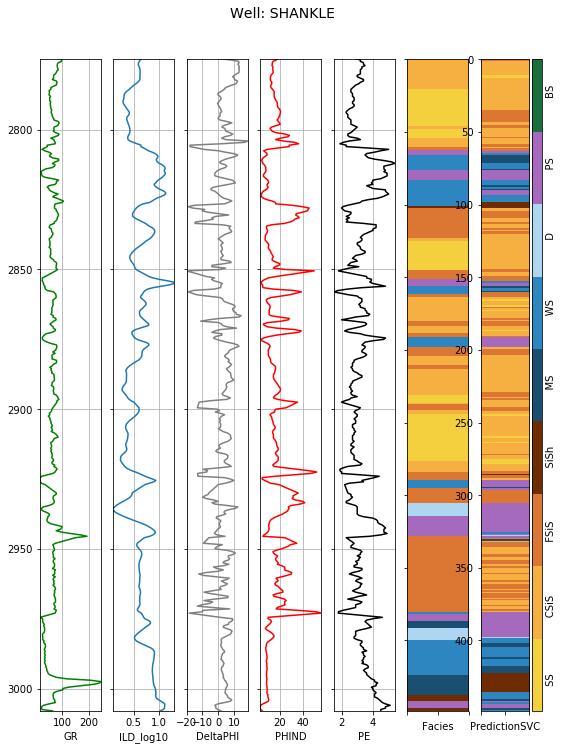

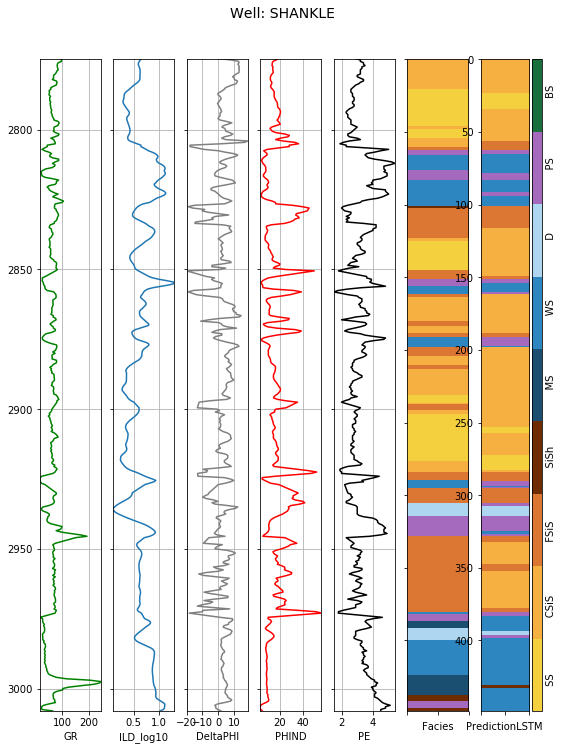

In [8]:
import matplotlib.pylab as plt
compare_facies_plot(all_wells['SHANKLE'], 'PredictionSVC', facies_colors)
plt.show()
compare_facies_plot(all_wells['SHANKLE'], 'PredictionLSTM', facies_colors)
plt.show()